<a href="https://colab.research.google.com/github/nghess/makemore/blob/main/makemore_lesson3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
import numpy as np
import urllib3
import random 
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Import text file

In [198]:
# Grab text file from github
http = urllib3.PoolManager()
textfile = http.request('GET', 'https://raw.githubusercontent.com/nghess/makemore/master/names.txt')
words = str(textfile.data, 'utf-8').splitlines()

In [199]:
# Take a peak at text file
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [200]:
# Build character to/from string mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
block_size = 3  # context length: how many characters do we use to predict the next one?

In [201]:
# Build the dataset
def build_dataset(words):

  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] #  Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [202]:
len(words)

32033

In [203]:
n_emb = 50
n_hidden = 200
n_chars = len(stoi)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((n_chars, n_emb), generator=g)
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3)/((n_emb*block_size)**0.5)  # Kaiming init
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, n_chars), generator=g) * 0.01
b2 = torch.randn(n_chars, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
  p.requires_grad = True

In [204]:
sum(p.nelement() for p in parameters)

37177

In [205]:
iters = 100000
batch_size = 32
lossi = []


# Forward pass
for i in range(iters):

  # Minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]  # Batch x, y

  # Forward pass
  emb = C[Xb]  # (32, 2, 2) by indexing into the dataset 
  embcat = emb.view(emb.shape[0], -1)
  # Linear layer
  hpreact = embcat @ W1 #+ b1
  # BatchNorm layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # Non-linearity
  h = torch.tanh(hpreact)  # Hidden layer
  logits = h @ W2 + b2  # Output layer
  loss = F.cross_entropy(logits, Yb)

  # Backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < int(iters/2) else 0.01 
  for p in parameters:
    p.data += -lr * p.grad

  # Track loss
  if i % 10000 == 0: # print every 10000 iters
    print(f'{i:7d}/{iters:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 100000: 3.2916
  10000/ 100000: 2.2236
  20000/ 100000: 2.0323
  30000/ 100000: 2.0138
  40000/ 100000: 2.1206
  50000/ 100000: 2.3848
  60000/ 100000: 2.2325
  70000/ 100000: 2.0151
  80000/ 100000: 2.3781
  90000/ 100000: 2.5805


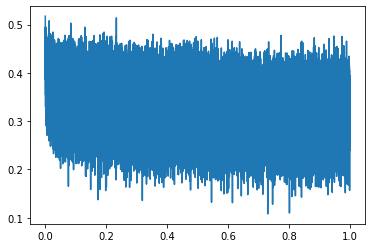

In [206]:
stepi = torch.linspace(0, 1, iters)
plt.plot(stepi, lossi)

In [207]:
lossi[1]

0.5173670649528503

In [208]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]  # (32, 2, 2) by indexing into the dataset 
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1
  hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running + bnbias)
  h = torch.tanh(hpreact)   # (N, nhidden)
  logits = h @ W2 + b2  # (N, vocab size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.150379180908203
val 2.193241834640503
